# Explore lru caching for pauli commutators

Add a `lru_cache` decorator to `PauliWord.commutator` method.

We should be careful with adding such caching decorators, because when used uncarefully, they may accumulate a lot of memory.

For that, **test how much memory is accumulated for a controlled number of operators (bonus: do a #ops vs memory graph).**

Also, **check for some of the larger molecular Hamiltonians with ~20 qubits:**

- **how much memory is accumulated and**
- **how large the speed-up is for computing different commutators.**

Some more background https://xanaduhq.slack.com/archives/C06DX049G49/p1706641024337299

AC:

Decision is made on whether or not to include lru cache
if positive, PR to include that merged

In [1]:
import pennylane as qml
from pennylane.pauli.pauli_arithmetic import PauliWord

## Random PauliWords generator

In [2]:
import random


def random_PauliWord_generator(
    lower_bound: int, upper_bound: int, directions: list = ["X", "Y", "Z"]
) -> PauliWord:
    "Generates a random Pauli Word."

    random.shuffle(directions)
    Pauli_arg = {}
    for i in range(lower_bound, upper_bound):
        if i - lower_bound < len(directions):
            Pauli_arg[i] = directions[i - lower_bound]
        else:
            Pauli_arg[i] = random.choice(directions)
    return PauliWord(Pauli_arg)

# Measuring cache memory usage

In [3]:
def CacheMemoryUsage(num_commutators, lower_bound, upper_bound, repetitions_allowed):
    "Measures how much cache memory is allocated."

    PauliWord.commutator.clear()

    iterations = list(range(1, num_commutators + 1))
    memory_usage = []
    counter = 0

    while counter < num_commutators:

        bounds = [
            random.randint(lower_bound, upper_bound),
            random.randint(lower_bound, upper_bound),
        ]
        bounds.sort()
        random_PauliWord_1 = random_PauliWord_generator(bounds[0], bounds[1])
        random_PauliWord_2 = random_PauliWord_generator(bounds[0], bounds[1])

        if not repetitions_allowed:
            if (
                str(random_PauliWord_1),
                str(random_PauliWord_2),
            ) in PauliWord.commutator.cache_mem_tracker:
                continue

        counter += 1
        random_PauliWord_1.commutator(random_PauliWord_2)
        memory_usage.append(PauliWord.commutator.tot_cache_mem_allocated())

    if not repetitions_allowed:
        assert len(PauliWord.commutator.cache_mem_tracker) == num_commutators

    # TODO: label should be more complete, but we don't care about it
    if repetitions_allowed:
        label = f"Repetitions: {repetitions_allowed}, Max qbits: {upper_bound-lower_bound+1}"
    else:
        label = f"Repetitions: {repetitions_allowed}"

    # DOUBLE CHECK
    # If `REPETITIONS_ALLOWED` is `False`, then `num_commutators` should be equal to `currsize` displayed below
    print(PauliWord.commutator.cache.cache_info())

    return iterations, memory_usage, label

In [4]:
N_COMMUTATORS = 100
LOWER_BOUND = 0
UPPER_BOUND_LIST = [9, 2, 3, 5, 9]
REPETITIONS_ALLOWED_LIST = [False, True, True, True, True]

data = []

for upper_bound, repetitions_allowed in zip(UPPER_BOUND_LIST, REPETITIONS_ALLOWED_LIST):
    iterations, memory_usage, label = CacheMemoryUsage(
        N_COMMUTATORS,
        LOWER_BOUND,
        upper_bound,
        repetitions_allowed,
    )
    data.append([iterations, memory_usage, label])

# data[ITERATION_INDEX][DATA_INDEX]
# DATA_INDEX = 0 --> iterations
# DATA_INDEX = 1 --> memory allocated
# DATA_INDEX = 2 --> label

CacheInfo(hits=0, misses=100, maxsize=None, currsize=100)
CacheInfo(hits=68, misses=32, maxsize=None, currsize=32)
CacheInfo(hits=45, misses=55, maxsize=None, currsize=55)
CacheInfo(hits=28, misses=72, maxsize=None, currsize=72)
CacheInfo(hits=14, misses=86, maxsize=None, currsize=86)


## Plotting

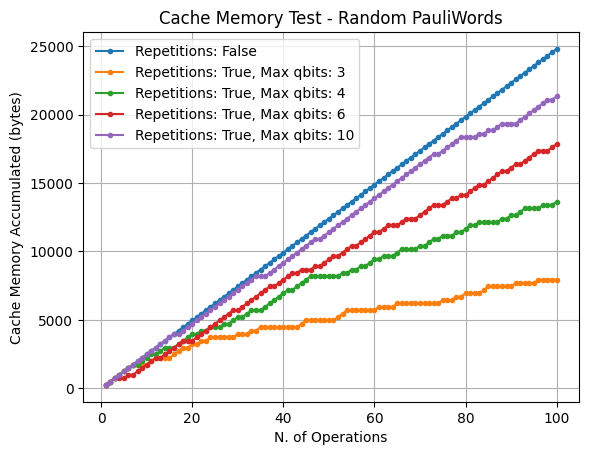

In [6]:
import matplotlib.pyplot as plt

SAVE_FIGURE = False

for iteration_idx in range(len(data)):
    plt.plot(
        data[iteration_idx][0],
        data[iteration_idx][1],
        label=data[iteration_idx][2],
        marker="o",
        markersize=3,
    )
plt.xlabel("N. of Operations")
plt.ylabel("Cache Memory Accumulated (bytes)")
plt.title(f"Cache Memory Test - Random PauliWords")
plt.grid(True)
plt.legend()
if SAVE_FIGURE:
    plt.savefig("./plots/CacheMemoryUsage.png")
plt.show()

## First comments: 

- There's not even need to perform a fit, since the memory accumulated is clearly **linear** in the number of computed commutators.
This makes a lot of sense, considering that all results stored in `PauliWord.commutator.cache_mem_tracker` have the same size (248 bytes). 
This is the size corresponding to a `PauliWord` and a `PauliSentence`.

- Increasing the gap between `UPPER_BOUND` and `LOWER_BOUND` up to 1000 units (wires) doesn't seems to affect the allocated memory at all.

- On the other hand, increasing the gap between `UPPER_BOUND` and `LOWER_BOUND` reduces the probability for the cache memory to be used, since the probability that two equal `PauliWords` are generated in the random process decreases accordingly.